<a href="https://colab.research.google.com/drive/1DcH9QM0FP-FjFSmvo5-hTLt2cdSueUgW?usp=drive_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum 1**
Klasifikasi Gambar (Day vs Night) dengan Neural Network.

**Membangun & Ekspor Model**

Pada praktikum bagian pertama ini, kita akan melatih model dan menyimpan "artefak" (file hasil training) yang dibutuhkan untuk deployment. Dengan melakukan Klasifikasi Gambar (Day vs Night) mengunakan Neural Network.

Unduh dataset berikut,

[images.zip](https://3041032130-files.gitbook.io/~/files/v0/b/gitbook-x-prod.appspot.com/o/spaces%2F5CvtE8Xh9b75jKUaRr5Y%2Fuploads%2FPS7Ex7o5Yo4EClMEuPGE%2Fimages.zip?alt=media&token=86b8ed48-d5b1-4ac0-bf07-1482521c21fc)

**Langkah 1: Import Library dan Mount Google Drive**

Langkah pertama adalah mengimpor pustaka yang diperlukan untuk pengolahan citra, machine learning, dan deep learning, serta menghubungkan Google Colab dengan Google Drive.

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Langkah 2: Load Dataset**

Membaca gambar dari direktori training dan testing, lalu menyimpannya dalam list bersama dengan labelnya.

Catatan: Sesuaikan path dengan lokasi folder images di Google Drive Anda masing-masing.

In [ ]:
# Load images and labels from a directory structure
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    for folder in p.glob('*'):
        label = folder.name
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append((img, label))
    return img_list

train_dir = "/content/drive/MyDrive/Machine Learning/Dataset/images/images/training"
test_dir  = "/content/drive/MyDrive/Machine Learning/Dataset/images/images/test"

train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Jumlah data training: {len(train_img)}")
print(f"Jumlah data testing: {len(test_img)}")

Jumlah data training: 254
Jumlah data testing: 160


**Langkah 3: Preprocessing (Resize & Label Encoding)**

Mengubah ukuran gambar menjadi 256x256 piksel dan mengubah label teks ('day'/'night') menjadi angka biner (1/0).

In [ ]:
# Preprocess images: resize and encode labels
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

**Langkah 4: Ekstraksi Fitur HOG (Histogram of Oriented Gradients)**

Mengekstraksi fitur bentuk dan tekstur dari gambar menggunakan metode HOG.

In [ ]:
# Extract HOG features
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

**Langkah 5: Normalisasi Fitur**

Menstandarisasi fitur agar memiliki rata-rata 0 dan variansi 1 menggunakan StandardScaler.

In [ ]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

**Langkah 6: Split Data Training & Validation**

Memisahkan data training menjadi data train dan validation.

In [ ]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

**Langkah 7: Konversi Label ke Numpy Array**

Mengubah list label menjadi format numpy array agar kompatibel dengan TensorFlow/Keras.

In [ ]:
# Convert labels to numpy arrays (required for Keras)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

**Langkah 8: Membangun Arsitektur Model Neural Network**

Membuat model Sequential dengan 3 layer (Input, Hidden Layers dengan ReLU, dan Output Layer dengan Sigmoid).

In [ ]:
# Build a simple feedforward neural network
# Define model architecture
# input_dim is the number of features in the dataset
# Hidden layer -> 128 neurons, ReLU activation
# Hidden layer -> 64 neurons, ReLU activation
# Output layer -> 1 neuron, Sigmoid activation (for binary classification)
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

**Langkah 9: Training Model**

Melatih model menggunakan data training selama 20 epoch.

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.7425 - loss: 0.7037 - val_accuracy: 0.9804 - val_loss: 0.1548
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9835 - loss: 0.1141 - val_accuracy: 1.0000 - val_loss: 2.3988e-06
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.1509e-05 - val_accuracy: 1.0000 - val_loss: 3.6618e-04
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.7003e-05 - val_accuracy: 0.9608 - val_loss: 0.0822
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.4211e-05 - val_accuracy: 0.9608 - val_loss: 0.2118
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.7490e-05 - val_accuracy: 0.9608 - val_loss: 0.2831
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.3520e-05 - val_accuracy: 0.9608 - val_loss: 0.3190
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 5.6904e-06 - val_acc

**Langkah 10: Evaluasi Model**

Menguji performa model pada data testing.

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print("Akurasi Test:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9353 - loss: 0.9504 
Akurasi Test: 0.90625


**Langkah 11: Prediksi dan Laporan Klasifikasi serta Visualisasi**

Membuat prediksi pada data test dan menampilkan classification report serta confusion matrix.

In [ ]:
# Generate classification report and confusion matrix
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        80
           1       0.87      0.96      0.91        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160

[[68 12]
 [ 3 77]]


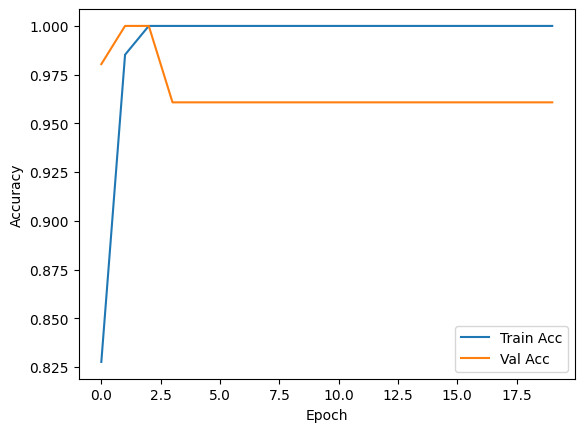

In [ ]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Langkah 12: Menyimpan Model dan Scaler**

Menyimpan model yang sudah dilatih ke dalam format .h5 dan scaler ke format .pkl untuk penggunaan deployment.

In [ ]:
# Save the trained model
import pickle

# 1. Simpan Model
# Menggunakan format .h5
model.save('day_night_model.h5')
print("✅ Model berhasil disimpan sebagai: day_night_model.h5")

# 2. Simpan Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler berhasil disimpan sebagai: scaler.pkl")

✅ Model berhasil disimpan sebagai: day_night_model.h5
✅ Scaler berhasil disimpan sebagai: scaler.pkl
